In [1]:
import dask.dataframe as dd
import dask.array as da
import os
import csv
import numba
import numpy as np
import math as m
from tqdm import tqdm_notebook
import pandas as pd
import dask
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io as sio
from skimage import exposure
from scipy.interpolate import interp1d
import dask_full_scene_analysis_helpers as hlp

In [10]:
solar_path = 'Aug14SolarRef.dat'
HySICS_wl_path = 'HySICS files/WLHysics.sav'

HySICS_LW_data_path = 'Desert_vegetation_clouds/'
LW_datacube_path = 'data_cube_water.npy'
LW_sample_path = 'HySICS files/DSSampleHysics.sav'
LW_rgb_path = 'rgb_water.npy'
LRT_LW_path = 'WC files/'
verbose_LW_path = 'WC files/verbose/'

HySICS_IC_data_path = 'Thick_clouds1/'
IC_datacube_path = 'data_cube_ice.npy'
IC_sample_path = 'HySICS files/CLSampleHysics.sav'
IC_rgb_path = 'rgb_ice.npy'
LRT_IC_path = 'IC files/'
verbose_IC_path = 'IC files/verbose/'

path = LRT_IC_path
phase='Ice'
wl_num=15

In [38]:
def read_HySICS(file, wl_file, phase):
    wlHy = sio.readsav(wl_file)
    wlHy = wlHy['wlsample']
    wlHy_shifted = [x+3.5 for x in wlHy]
    
    cloud = sio.readsav(file)
    cloud = cloud['dssample'] if phase == 'Liquid Water' else cloud['clsample']
    hysics = xr.DataArray(cloud, dims=['wavelength'], name='hysics_radiances', coords={'wavelength':wlHy_shifted})
    return hysics;
hysics = read_HySICS(IC_sample_path,HySICS_wl_path,phase)
hysics

<xarray.DataArray 'hysics_radiances' (wavelength: 640)>
array([ 0.004165,  0.003928,  0.004006, ...,  0.29397 , -0.65386 ,  0.040075])
Coordinates:
  * wavelength  (wavelength) float64 2.305e+03 2.302e+03 ... 331.1 328.1

Text(0.5, 1.0, 'Sample HySICS Thick Cloud Spectra')

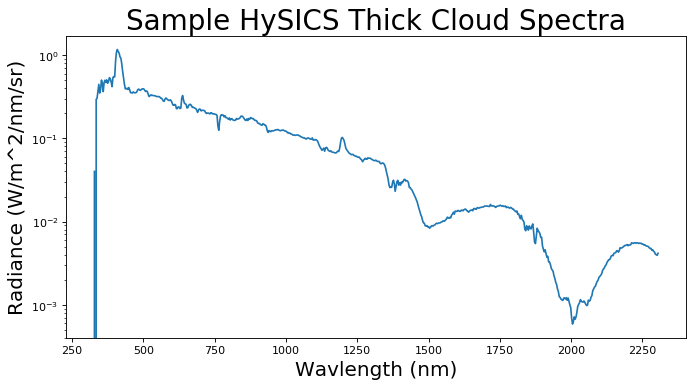

In [39]:
plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.semilogy(hysics.wavelength,hysics.values)
plt.xlabel('Wavlength (nm)',fontsize=18)
plt.ylabel('Radiance (W/m^2/nm/sr)',fontsize=18)
tt = 'Sample HySICS Thick Cloud Spectra'
plt.title(tt,fontsize=25)

In [40]:
def read_solar(file):
    d = np.loadtxt(file, delimiter="\t")
    solar_wl=d[:,0]
    solar_flux=d[:,1]
    solar_flux = np.array([i/1000 for i in solar_flux]) 
    solar = xr.DataArray(solar_flux,dims=['wavelength'], name='solar flux', coords={'wavelength':solar_wl})
    return solar; 

solar = read_solar(solar_path) 
solar

<xarray.DataArray 'solar flux' (wavelength: 2500)>
array([1.58e-05, 2.52e-05, 8.50e-05, ..., 4.37e-02, 4.36e-02, 4.35e-02])
Coordinates:
  * wavelength  (wavelength) float64 115.5 116.5 117.5 ... 2.614e+03 2.614e+03

Text(0.5, 1.0, 'NRLSSI2 Solar Data for August 18th, 2014')

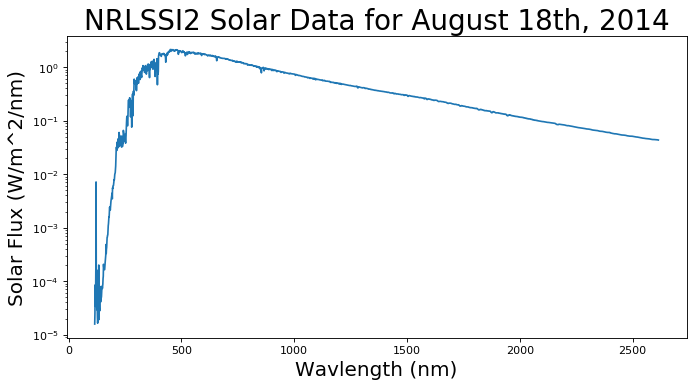

In [41]:
plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.semilogy(solar.wavelength,solar.values)
plt.xlabel('Wavlength (nm)',fontsize=18)
plt.ylabel('Solar Flux (W/m^2/nm)',fontsize=18)
tt = 'NRLSSI2 Solar Data for August 18th, 2014'
plt.title(tt,fontsize=25)

In [21]:
file = 'IC files/Clouds1_IC1.5650133333333334_r40_t192_ghm.dat'
data = [x for x in csv.reader(open(file,'r'),delimiter='\t')]  
data = data[5:]

In [24]:
def read_verbose(verbose_file,phase):
    data = [x for x in open(verbose_file,'r')]
    a = data.index('Using new intensity correction, with phase functions\n')
    n=4 if phase=='Liquid Water' else 5
    tau = data[a:][67].split('|')[n].split()[0]
    return(tau);

def read_LRT(file,phase):
    fs = file.split('_')
    reff = fs[3][1:] if phase =='Liquid Water' else fs[2][1:]
    
    fv = file.split('/')
    ff = fv[1][0:-4] if phase =='Liquid Water' else fv[1][0:-4]
    end = '_550nm_verbose.txt'
    verbose_file = fv[0]+'/verbose/'+ff+end
    tau = read_verbose(verbose_file,phase)
    
    data = [x for x in csv.reader(open(file,'r'),delimiter='\t')]  
    data = data[3:] if phase == 'Liquid Water' else data[5:] 
    
    loops = int(len(data)/3)
    dirL = [np.float(data[3*n+2][0][9:24]) for n in range(loops)]#Direct Radiance (W/m^2/nm/sr)
    wl = [np.float(data[3*n][0][1:9]) for n in range(loops)]#Wavelength (nm)       

    dirLW = [i*10**-3 for i in dirL] #convert to W/m^2/nm/sr
    
    lrt_radiances = xr.DataArray(dirLW, dims=['wavelength'], name='LRT', coords={'wavelength':wl})
    lrt_radiances.attrs['COT'] = tau
    lrt_radiances.attrs['r_eff'] = reff
    return lrt_radiances;

def filter_wl(da):
    wl_min = 450 ; wl_max = 2300
    daf = da.where(da.wavelength>wl_min, drop=True)
    daf = daf.where(da.wavelength<wl_max, drop=True)
    return daf;

def get_sample_lrt_radf(path,phase):
    files = [os.path.join(path,f) for f in os.listdir(path)]
    file = files[0]
    lrt_rad = read_LRT(file,phase)
    lrt_radf_samp = filter_wl(lrt_rad)
    return (files, lrt_radf_samp);

lrt_files, lrt_radf_samp = get_sample_lrt_radf(path,phase)
lrt_radf_samp

<xarray.DataArray (wavelength: 583)>
array([0.133848, 0.130877, 0.13377 , ..., 0.004748, 0.004632, 0.00444 ])
Coordinates:
  * wavelength  (wavelength) float64 451.5 454.5 457.5 ... 2.194e+03 2.198e+03
Attributes:
    COT:      3.725382
    r_eff:    22.5

Text(0.5, 1.0, 'Sample LibRadtran Ice Cloud Spectra')

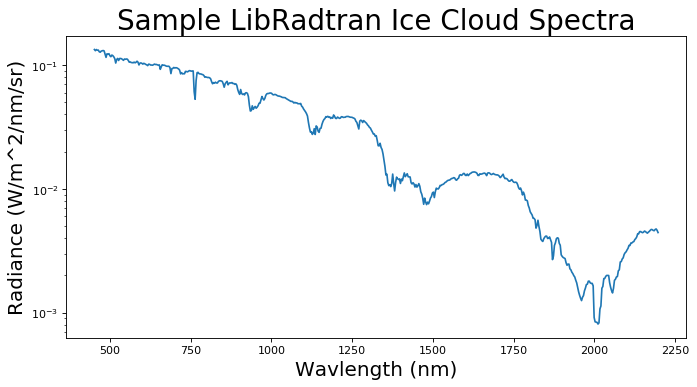

In [25]:
plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.semilogy(lrt_radf_samp.wavelength,lrt_radf_samp.values)
plt.xlabel('Wavlength (nm)',fontsize=18)
plt.ylabel('Radiance (W/m^2/nm/sr)',fontsize=18)
tt = 'Sample LibRadtran Ice Cloud Spectra'
plt.title(tt,fontsize=25)

In [26]:
def interpolate_solar(lrt_radf,solar):
    f = interp1d(solar.wavelength,solar.values,fill_value='NaN')
    solar_new = f(lrt_radf.wavelength)
    
    solar_interp = xr.DataArray(solar_new,dims=['wavelength'], name='interpolated solar flux', coords={'wavelength':lrt_radf.wavelength})
    return solar_interp;

solar_interp = interpolate_solar(lrt_radf_samp,solar)
solar_interp

<xarray.DataArray 'interpolated solar flux' (wavelength: 583)>
array([2.14  , 2.07  , 2.13  , ..., 0.0839, 0.0836, 0.0835])
Coordinates:
  * wavelength  (wavelength) float64 451.5 454.5 457.5 ... 2.194e+03 2.198e+03

Text(0.5, 1.0, 'Interpolated NRLSSI2 Solar Data')

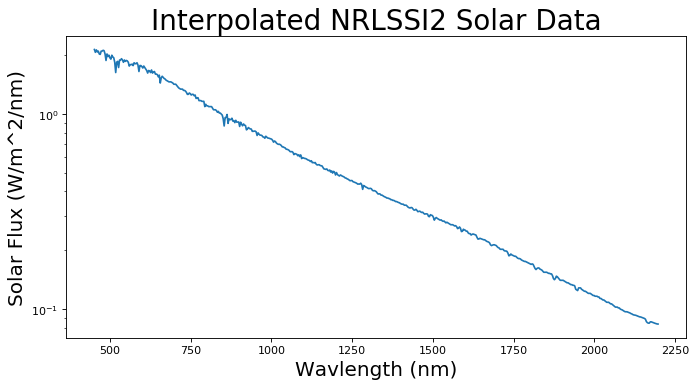

In [27]:
plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.semilogy(solar_interp.wavelength,solar_interp.values)
plt.xlabel('Wavlength (nm)',fontsize=18)
plt.ylabel('Solar Flux (W/m^2/nm)',fontsize=18)
tt = 'Interpolated NRLSSI2 Solar Data'
plt.title(tt,fontsize=25)

In [29]:
def calc_LRT_reflectance(lrt_radf,solar_interp,phase):
    sza = 38.5 if phase == 'Liquid Water' else 56
    mu = m.cos(m.radians(sza))
    refl_lrt = [np.pi/mu*lrt_radf.values[w]/solar_interp.values[w] for w in np.arange(0,len(lrt_radf.wavelength))]
                                                                        
    refl_lrt = xr.DataArray(refl_lrt,dims=['wavelength'], name='lrt reflectances', coords={'wavelength':lrt_radf.wavelength})
    refl_lrt.attrs['COT'] = lrt_radf.attrs['COT']
    refl_lrt.attrs['r_eff'] = lrt_radf.attrs['r_eff']   
    refl_lrt.attrs['rad'] = lrt_radf.values
    return refl_lrt;

def gen_refl_lrt_list(files,solar_interp,phase):
    refl_lrt_list = []
    lrt_rads = [read_LRT(f,phase) for f in files if f.endswith('.dat')]
    lrt_radfs = [filter_wl(lrt_rad)for lrt_rad in lrt_rads]
    refl_lrts = [calc_LRT_reflectance(r,solar_interp,phase) for r in lrt_radfs]
    return (refl_lrts);

refl_lrt_list = gen_refl_lrt_list(lrt_files,solar_interp,phase)
refl_lrt_list[0]

<xarray.DataArray 'lrt reflectances' (wavelength: 583)>
array([0.351387, 0.355208, 0.352831, ..., 0.317912, 0.311284, 0.298731])
Coordinates:
  * wavelength  (wavelength) float64 451.5 454.5 457.5 ... 2.194e+03 2.198e+03
Attributes:
    COT:      3.725382
    r_eff:    22.5
    rad:      [0.1338477  0.13087746 0.13376974 0.13204414 0.13239462 0.12838...

Text(0.5, 1.0, 'Sample LibRadtran Ice Cloud Reflectance')

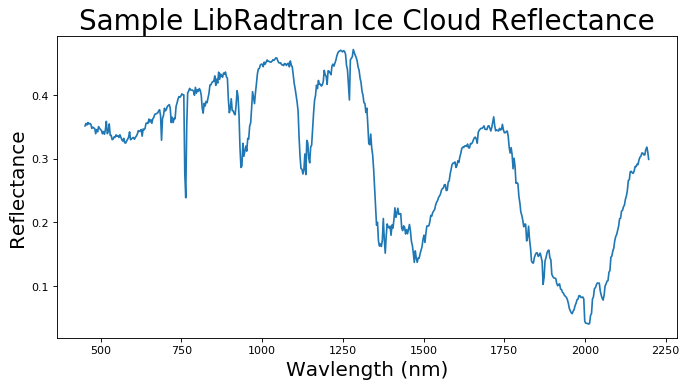

In [31]:
plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(refl_lrt_list[0].wavelength,refl_lrt_list[0].values)
plt.xlabel('Wavlength (nm)',fontsize=18)
plt.ylabel('Reflectance',fontsize=18)
tt = 'Sample LibRadtran Ice Cloud Reflectance'
plt.title(tt,fontsize=25)

In [32]:
def find_retrieval_wavelengths(num_wl): 
    if num_wl%5 !=0: print('Number of wavelengths in algorithm must be a factor of 5.')   
    
    if (num_wl ==5):
        retrieval_wl_list=[[750], [1000], [1200], [1660], [2200]]
    else:
        wl_lims = [[600,750], [1000,1080], [1240,1320], [1600,1750], [2100,2200]]
        num = num_wl/5
        retrieval_wl_list = [np.linspace(wl_lims[w][0],wl_lims[w][1],num) for w in np.arange(0,5)]
    
    return retrieval_wl_list;

wl_num=15
retrieval_wl_list = find_retrieval_wavelengths(wl_num)
retrieval_wl_list

/ncar/usr/jupyterhub/envs/pangeo-3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


[array([600., 675., 750.]),
 array([1000., 1040., 1080.]),
 array([1240., 1280., 1320.]),
 array([1600., 1675., 1750.]),
 array([2100., 2150., 2200.])]

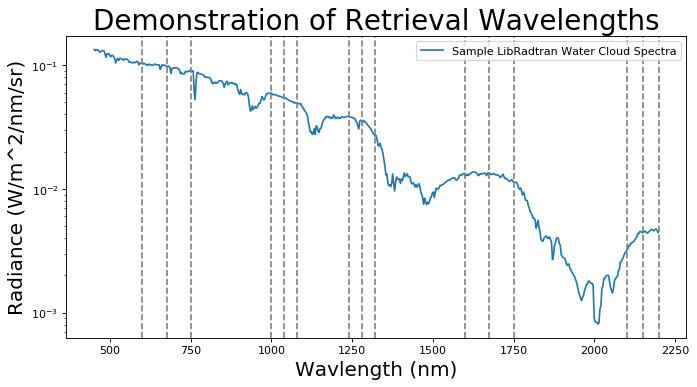

In [33]:
plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.semilogy(lrt_radf_samp.wavelength,lrt_radf_samp.values,label='Sample LibRadtran Water Cloud Spectra')
[plt.axvline(w,linestyle='--',c='grey') for w in np.ravel(retrieval_wl_list)]
plt.xlabel('Wavlength (nm)',fontsize=18)
plt.ylabel('Radiance (W/m^2/nm/sr)',fontsize=18)
tt = 'Demonstration of Retrieval Wavelengths'
plt.title(tt,fontsize=25)
plt.legend()

In [34]:
def find_retrieval_idx_list(retrieval_wl_list,solar_interp):   
    idx_list = []
    for i in np.arange(0,5):
        cols = []
        for j in np.arange(0,len(retrieval_wl_list[0])):
            a = [np.min(np.abs(retrieval_wl_list[i][j] - x)) for x in solar_interp.wavelength] 
            val, idx = min((val, idx) for (idx, val) in enumerate(a))
            cols.append(int(idx))
        idx_list.append(cols)
    return idx_list;

retrieval_idx_list = find_retrieval_idx_list(retrieval_wl_list,solar_interp)
retrieval_idx_list

[[49, 74, 99],
 [183, 196, 209],
 [263, 276, 289],
 [383, 408, 433],
 [549, 566, 582]]

In [42]:
def calc_HySICS_reflectance(hysics,solar_interp,phase):    
    f = interp1d(hysics.wavelength,hysics.values,fill_value='NaN')
    hy_new = f(solar_interp.wavelength)
    
    sza = 38.5 if phase == 'Liquid Water' else 56
    mu = m.cos(m.radians(sza))
    refl_HySICS= [np.pi/mu*hy_new[w]/solar_interp.values[w] for w in np.arange(0,len(solar_interp.wavelength))]
    
    refl_hysics = xr.DataArray(refl_HySICS,dims=['wavelength'], name='HySICS reflectance', coords={'wavelength':solar_interp.wavelength})
    return refl_hysics;

refl_hysics = calc_HySICS_reflectance(hysics,solar_interp,phase)
refl_hysics

<xarray.DataArray 'HySICS reflectance' (wavelength: 583)>
array([1.009458, 0.970046, 0.933485, ..., 0.346255, 0.352073, 0.353522])
Coordinates:
  * wavelength  (wavelength) float64 451.5 454.5 457.5 ... 2.194e+03 2.198e+03

Text(0.5, 1.0, 'HySICS Thick Ice Cloud Reflectance')

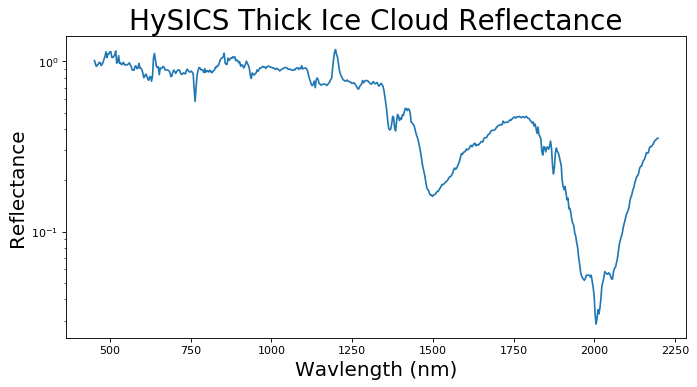

In [43]:
plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.semilogy(refl_hysics.wavelength,refl_hysics.values)
plt.xlabel('Wavlength (nm)',fontsize=18)
plt.ylabel('Reflectance',fontsize=18)
tt = 'HySICS Thick Ice Cloud Reflectance'
plt.title(tt,fontsize=25)

In [44]:
def find_sigma_k_j(refl_lrt,refl_hysics,idx_1,k,j):
    reflectance_term = (5-k)**2*(refl_lrt.values[j]-refl_hysics.values[j])**2
    ratio_term = (k-1)**2*(refl_lrt.values[j]/refl_lrt.values[idx_1]- refl_hysics.values[j]/refl_hysics.values[idx_1])**2
    sigma_k_j = reflectance_term + ratio_term
    return sigma_k_j

def find_sigma_k(refl_lrt,refl_hysics,retrieval_idx_list,idx_1,i):
    k = i+1
    sigma_k = [find_sigma_k_j(refl_lrt,refl_hysics,idx_1,k,j) for j in retrieval_idx_list[i]] 
    return sigma_k

def calc_disagreement(refl_hysics,refl_lrt,retrieval_idx_list):  
    idx_1 = retrieval_idx_list[0][0]
    
    sigma_all = [find_sigma_k(refl_lrt,refl_hysics,retrieval_idx_list,idx_1,i) for i in np.arange(0,5)] 
    
    sigma = np.sum(sigma_all)
    chi_sq = sigma/(len(retrieval_idx_list[0])*60) 
    diff = np.sqrt(chi_sq)*100
    
    disagreement = xr.DataArray(diff)
    disagreement.attrs['COT'] = refl_lrt.attrs['COT']
    disagreement.attrs['r_eff'] = refl_lrt.attrs['r_eff']
    disagreement.attrs['LRT rad'] = refl_lrt.attrs['rad']
    disagreement.attrs['wavelength'] = refl_lrt.wavelength
    return disagreement;
  
diff_list = [calc_disagreement(refl_hysics, r, retrieval_idx_list) for r in refl_lrt_list]
best_diff, idx_diff = min((val, idx) for (idx, val) in enumerate(diff_list))
best_diff

<xarray.DataArray ()>
array(4.450421)
Attributes:
    COT:         179.278942
    r_eff:       20
    LRT rad:     [0.3382027  0.33118097 0.33931589 0.33556268 0.33677673 0.32...
    wavelength:  <xarray.DataArray 'wavelength' (wavelength: 583)>\narray([ 4...

In [45]:
reffs = [d.attrs['r_eff'] for d in diff_list]
COTs = [d.attrs['COT'] for d in diff_list]
diffs = [d.values for d in diff_list]

(40, 200)

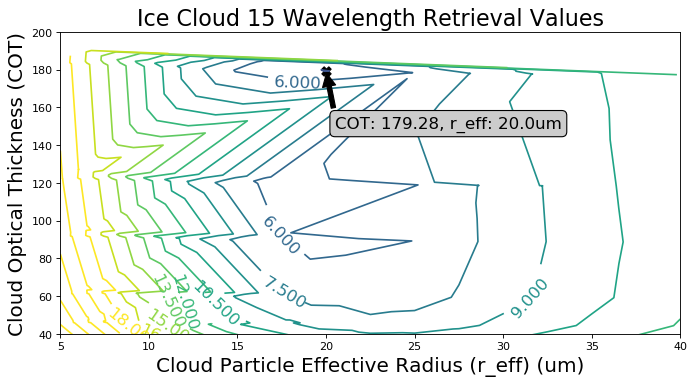

In [52]:
def chi_sq_contour(reffs,COTs,diffs,best_diff):           
    plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
    
    cnorm = mpl.colors.Normalize(vmin=0.,vmax=18.)
    
    x = reffs
    y = COTs
    z = diffs
    b = plt.tricontour(x,y,z,70,norm=cnorm)
    
    plt.xlabel('Cloud Particle Effective Radius (r_eff) (um)',fontsize=18)
    plt.ylabel('Cloud Optical Thickness (COT)',fontsize=18)
    plt.title(phase+' Cloud {} Wavelength Retrieval Values'.format(str(wl_num)),fontsize=20)
    plt.clabel(b, inline=1, fontsize=15)
    
    reff_best = float(best_diff.attrs['r_eff'])
    COT_best = float(best_diff.attrs['COT'])
    
    COT_rounded = round(COT_best,2)
    label = str('COT: '+str(COT_rounded)+', r_eff: '+str(reff_best)+'um')
    
    bbox = dict(boxstyle="round", fc="0.8",alpha=1)
    arrow = dict(facecolor='black', shrink=0.05)
    plt.annotate(label,[reff_best,COT_best],xytext=(reff_best+0.5,COT_best-30),bbox=bbox,fontsize=15,arrowprops=arrow)
    plt.scatter(reff_best,COT_best,marker="X",c='k',s=70)
    return;

chi_sq_contour(reffs,COTs,diffs,best_diff)
plt.xlim(5,40)
plt.ylim(40,200)

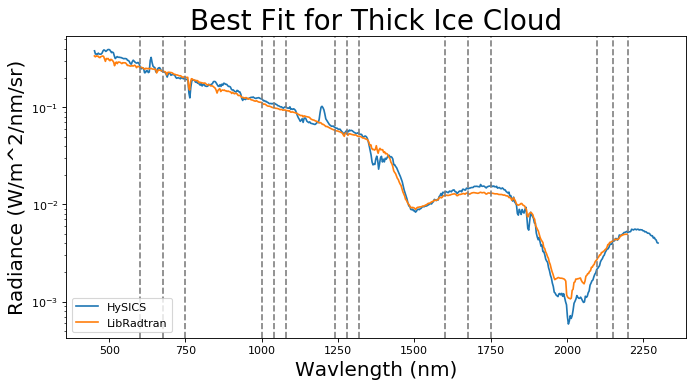

In [53]:
hysicsf = filter_wl(hysics)

plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.semilogy(hysicsf.wavelength, hysicsf.values,label='HySICS')
plt.semilogy(best_diff.attrs['wavelength'], best_diff.attrs['LRT rad'], label='LibRadtran')
[plt.axvline(w,linestyle='--',c='grey') for w in np.ravel(retrieval_wl_list)]
plt.xlabel('Wavlength (nm)',fontsize=18)
plt.ylabel('Radiance (W/m^2/nm/sr)',fontsize=18)
tt = 'Best Fit for Thick Ice Cloud'
plt.title(tt,fontsize=25)
plt.legend()

(750, 780)

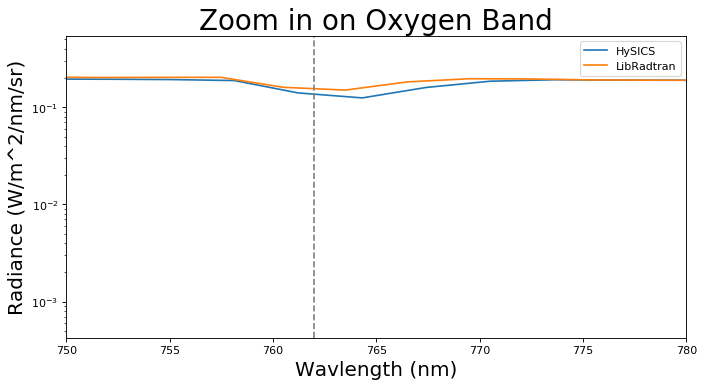

In [60]:
plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.semilogy(hysicsf.wavelength, hysicsf.values,label='HySICS')
plt.semilogy(best_diff.attrs['wavelength'], best_diff.attrs['LRT rad'], label='LibRadtran')
plt.axvline(762,linestyle='--',c='grey')
plt.xlabel('Wavlength (nm)',fontsize=18)
plt.ylabel('Radiance (W/m^2/nm/sr)',fontsize=18)
tt = 'Zoom in on Oxygen Band'
plt.title(tt,fontsize=25)
plt.legend()
plt.xlim(750,780)

/ncar/usr/jupyterhub/envs/pangeo-3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':
/ncar/usr/jupyterhub/envs/pangeo-3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':
/ncar/usr/jupyterhub/envs/pangeo-3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':
/ncar/usr/jupyterhub/envs/pangeo-3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':
/ncar/usr/jupyterhub/envs/pangeo-3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: ob

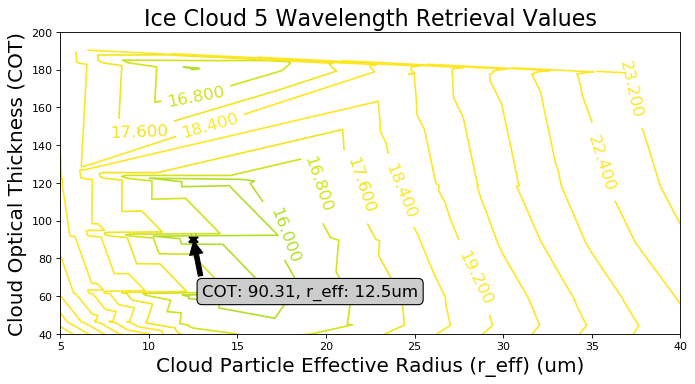

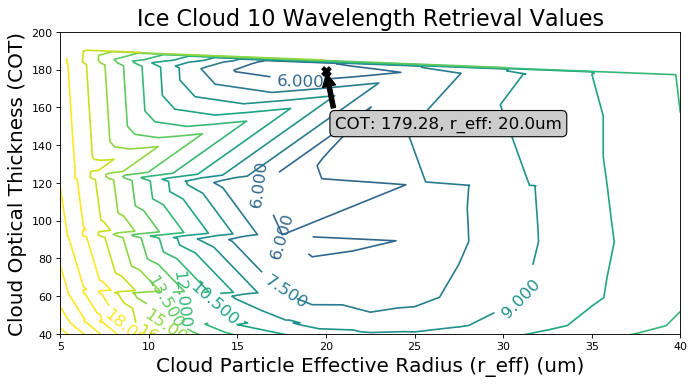

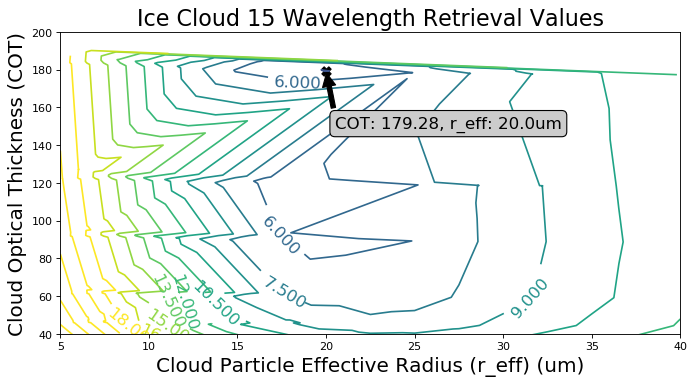

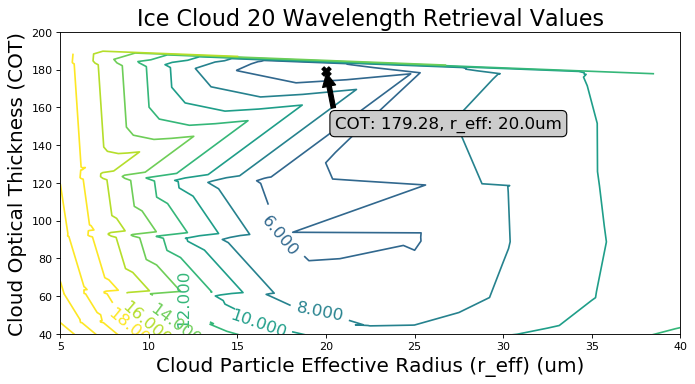

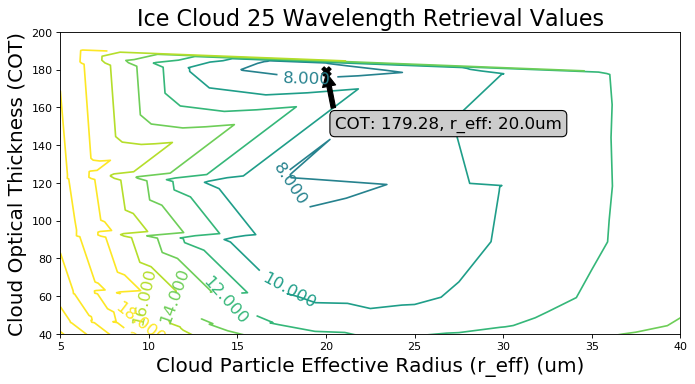

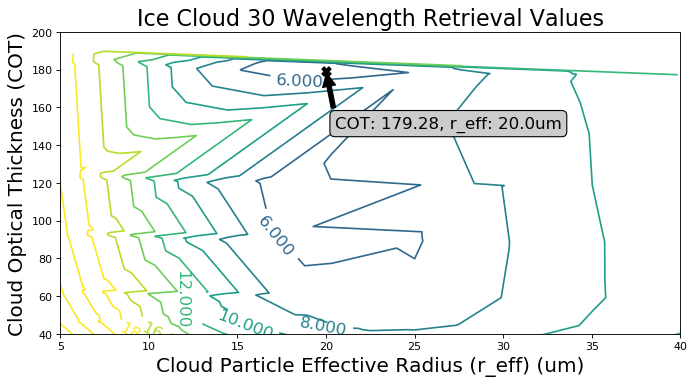

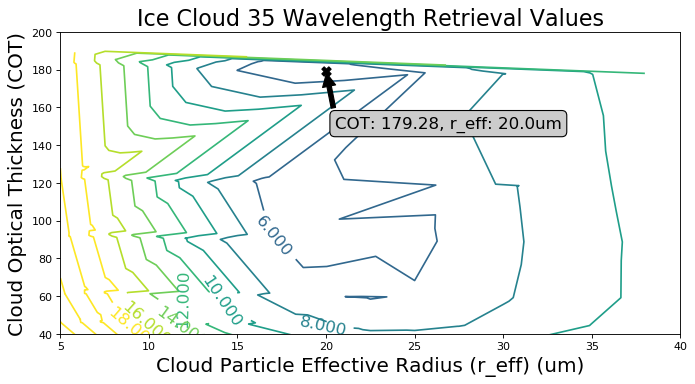

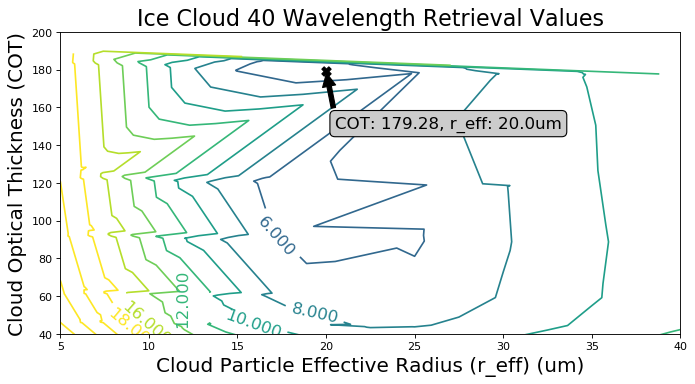

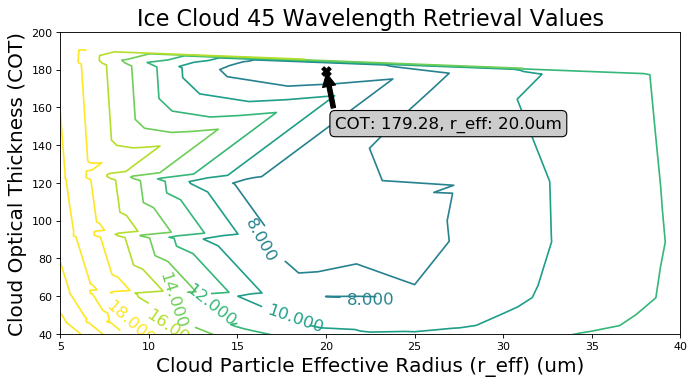

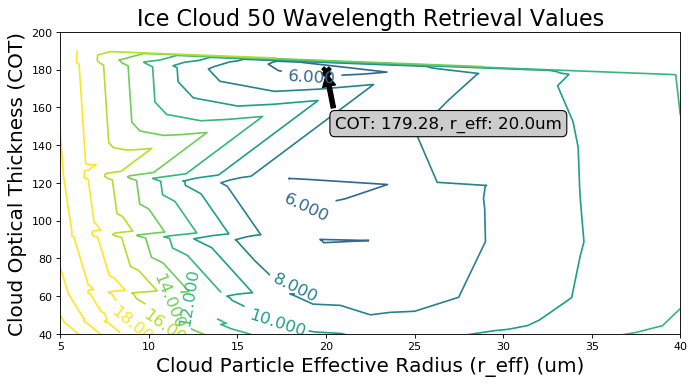

In [62]:
reff_r = []
COT_r = []
num_r = []
nums=np.arange(0,10)
dict_of_analysis_dicts={}
for n in nums:
    wl_num = (n+1)*5
    retrieval_wl_list = find_retrieval_wavelengths(wl_num)
    retrieval_idx_list = find_retrieval_idx_list(retrieval_wl_list,solar_interp)
    
    diff_list = [calc_disagreement(refl_hysics, r, retrieval_idx_list) for r in refl_lrt_list]
    best_diff, idx_diff = min((val, idx) for (idx, val) in enumerate(diff_list))
    
    reff_r.append(float(best_diff.attrs['r_eff']))
    COT_r.append(float(best_diff.attrs['COT']))
    num_r.append(wl_num)
    
    reffs = [d.attrs['r_eff'] for d in diff_list]
    COTs = [d.attrs['COT'] for d in diff_list]
    diffs = [d.values for d in diff_list]
    
    chi_sq_contour(reffs,COTs,diffs,best_diff)
    plt.xlim(5,40)
    plt.ylim(40,200)

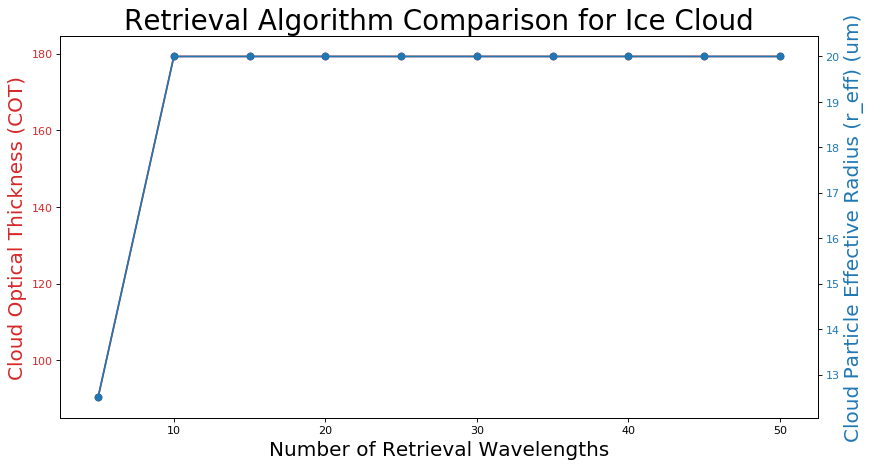

In [64]:
fig, ax1 = plt.subplots(figsize=(11, 6), dpi= 80, facecolor='w', edgecolor='k')
    
color = 'tab:red'
ax1.set_xlabel('Number of Retrieval Wavelengths', fontsize=18)
ax1.set_ylabel('Cloud Optical Thickness (COT)', color=color, fontsize=18)
ax1.plot(num_r, COT_r, color=color)
ax1.scatter(num_r, COT_r,c=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Cloud Particle Effective Radius (r_eff) (um)', color=color, fontsize=18)
ax2.plot(num_r, reff_r, color=color)
ax2.scatter(num_r, reff_r, c=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Retrieval Algorithm Comparison for '+phase+' Cloud',fontsize=25)
plt.show()